# Is there evidence of phylogeography in the protein sequence composition of soil viral communities?

Russell Neches, August 24, 2018

Phylogeography is the geographically structuring of genetic signals within and among species <cite data-cite="2799022/PJYDMATY"></cite>.  Here, I'll attempt to answer a simple question : is there a positive correlation between the phylogenetic distance between genetic elements and the geographic distance between them? This approach has been applied extensively to animal systems. See Table 1 from Avise *et al.* for a 
listing of foundational studies <cite data-cite="2799022/72DM6KWJ"></cite>. 

Rachel Whitacker and her group has applied this concept to [*sulfolobus islandicus*](https://microbewiki.kenyon.edu/index.php/Sulfolobus_islandicus) <cite data-cite="2799022/RK8T88Z9"></cite> <cite data-cite="2799022/ASH5A6YM"></cite> <cite data-cite="2799022/TZRJ39BC"></cite> and its viruses <cite data-cite="2799022/RXACUFM9"></cite>.

Here, we examine the 10,000 largest viral protein families for phylogeographic signal.

## Workflow

1. An all-verses-all alignment was performed with [LAST](http://last.cbrc.jp/) <cite data-cite="2799022/WE9SX2RW"></cite>
2. Alignment summary loaded in [`pandas`](https://pandas.pydata.org/) to remove self-to-self alignments <cite data-cite="2799022/5AYU4ZX7"></cite>
3. Alignment hits loaded as an undirected graph using [`networkx`](https://networkx.github.io/) <cite data-cite="2799022/QJJW2R8F"></cite>
4. Identify protein families by extracting connected components
5. Build multiple sequence alignments for protein families with [Clustal Omega](http://www.clustal.org/omega/) <cite data-cite="2799022/94BKJAJK"></cite>
6. Build approximate maximum likelihood phylogenetic trees for protein families with [`fasttree`](http://www.microbesonline.org/fasttree/) <cite data-cite="2799022/ZTE6IA6W"></cite>
7. Calculate correlation between phylogenetic and geographic distance
8. Correct p-values for multiple testing

In [1]:
%pylab inline
%config InlineBackend.figure_format='retina'
import pandas
import networkx
import pyprind
import seaborn
import random
import screed
from grave import grave
import cartopy.crs
from cartopy.io.img_tiles import OSM
from netCDF4 import Dataset
from Bio.SeqUtils import ProtParam
from SuchTree import SuchTree

import warnings
warnings.simplefilter( 'ignore', UserWarning )

Populating the interactive namespace from numpy and matplotlib


## Protein families

#### Alignment

First, we perform an all-vs-all alignment using [LAST](http://last.cbrc.jp/) of
all the putative viral genes.

In [ ]:
!lastdb -P 8 -cR01 -v -p svdb soil_viruses.faa
!lastal -P32 -v -f BlastTab+ svdb soil_viruses.faa > scratch/all_v_all.tsv

The `BlastTab+` output format for LAST has the following fields, delimited by tabs :

0. query id
* subject id
* % identity
* alignment length
* mismatches
* gap opens
* q. start
* q. end
* s. start
* s. end
* evalue
* bit score
* query length
* subject length
* raw score

There is also a long header escaped by `#` characters, and the column names are weirdly separated by commas and missing the last column. So, there's no way around parsing the column names separately.

In [2]:
df = pandas.read_csv( 'scratch/all_v_all.tsv', sep='\t', header=None, comment='#' )
df.columns = [ field.strip() for field in open( 'scratch/all_v_all.tsv' ).readlines()[35][10:].split(',') ] + ['raw score']
df.head()

,query id,subject id,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,s. end,evalue,bit score,query length,subject length,raw score
0,2088090008_____P3_DRAFT_NODE_290175_len_15711_...,2088090008_____P3_DRAFT_NODE_290175_len_15711_...,100.00,160,0,0,1,160,1,160,6.200000e-126,397.0,160,160,892
1,2088090008_____P3_DRAFT_NODE_290175_len_15711_...,3300002243_____C687J29039_10000481_____C687J29...,74.17,151,38,1,1,150,297,447,1.700000e-81,271.0,160,456,606
2,2088090008_____P3_DRAFT_NODE_290175_len_15711_...,3300014493_____Ga0182016_10005848_____Ga018201...,51.11,135,64,2,14,148,275,407,2.200000e-39,150.0,160,413,333
3,2088090008_____P3_DRAFT_NODE_290175_len_15711_...,3300006638_____Ga0075522_10000183_____Ga007552...,43.88,139,77,1,9,147,261,398,3.500000e-36,141.0,160,431,312
4,2088090008_____P3_DRAFT_NODE_290175_len_15711_...,3300001160_____JGI12654J13325_1000002_____JGI1...,47.06,136,71,1,9,144,267,401,8.200000e-35,137.0,160,411,303


In [3]:
# drop self-to-self alignments

df = df.where( df['subject id'] != df['query id'] ).dropna()

#### Alignment graph construction

Now that table of alignment summaries is ready, let's treat each alignment as an edge in an undirected graph. This has the (desirable) side effect of collapsing A-to-B and B-to-A alignments into a single edge. We'll use the LAST bit score of each alignment as the edge weight.

In [4]:
G = networkx.Graph()
G.add_nodes_from( set( df['query id'] ) | set( df['subject id'] ) )

progbar = pyprind.ProgBar( df.shape[0], title='adding graph edges...' )

for n,row in df.iterrows() :
    progbar.update()
    G.add_edge( row['subject id'], row['query id'], weight=row['bit score'] )

adding graph edges...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:17:51


#### Connected component extraction

Next, we decompose the alignment graph into its connected components. These are
our putative viral protein families.

In [5]:
# get the adjacency matrix in sparse form
aj = networkx.to_scipy_sparse_matrix(G)

# decompose graph into connected component subgraphs
components = sorted( networkx.connected_component_subgraphs(G), key=len, reverse=True )

#### Index and load protein sequence data

Some of our putative viral proteins do not align with anything else in the dataset, so
they're not present in the graph. So, let's index and load the sequence data.

In [6]:
import screed

screed.make_db( 'data/soil_viruses.faa' )
viralgenes = screed.ScreedDB( 'data/soil_viruses.faa' )

In [7]:
bit_min = min( df['bit score'] )
bit_max = max( df['bit score'] )
bit_med = median( df['bit score'] )

pandas.DataFrame.describe( df['bit score'] )

count    6.770267e+06
mean     2.821097e+02
std      2.904721e+02
min      4.740000e+01
25%      1.130000e+02
50%      1.950000e+02
75%      3.450000e+02
max      1.670000e+04
Name: bit score, dtype: float64

24% of the genes are in the giant hairball.

At the other end of the subgraph size distribution, we find a relatively short tail. 72% 
of genes align to at least one other gene, and 28% are singletons. 10% of genes fall into
components of four members or fewer.

Let's have a closer look at the medium-sized components. Here, I've made network plots
of 16 components, starting with the 300th to the 316th largest.

Node size represents the [closeness centrality](https://en.wikipedia.org/wiki/Closeness_centrality),
scaled to the maximum centrality (smaller nodes have a higher closeness). Edges are colored by the
bit score of the alignment.

#### Plot putative viral protein family networks

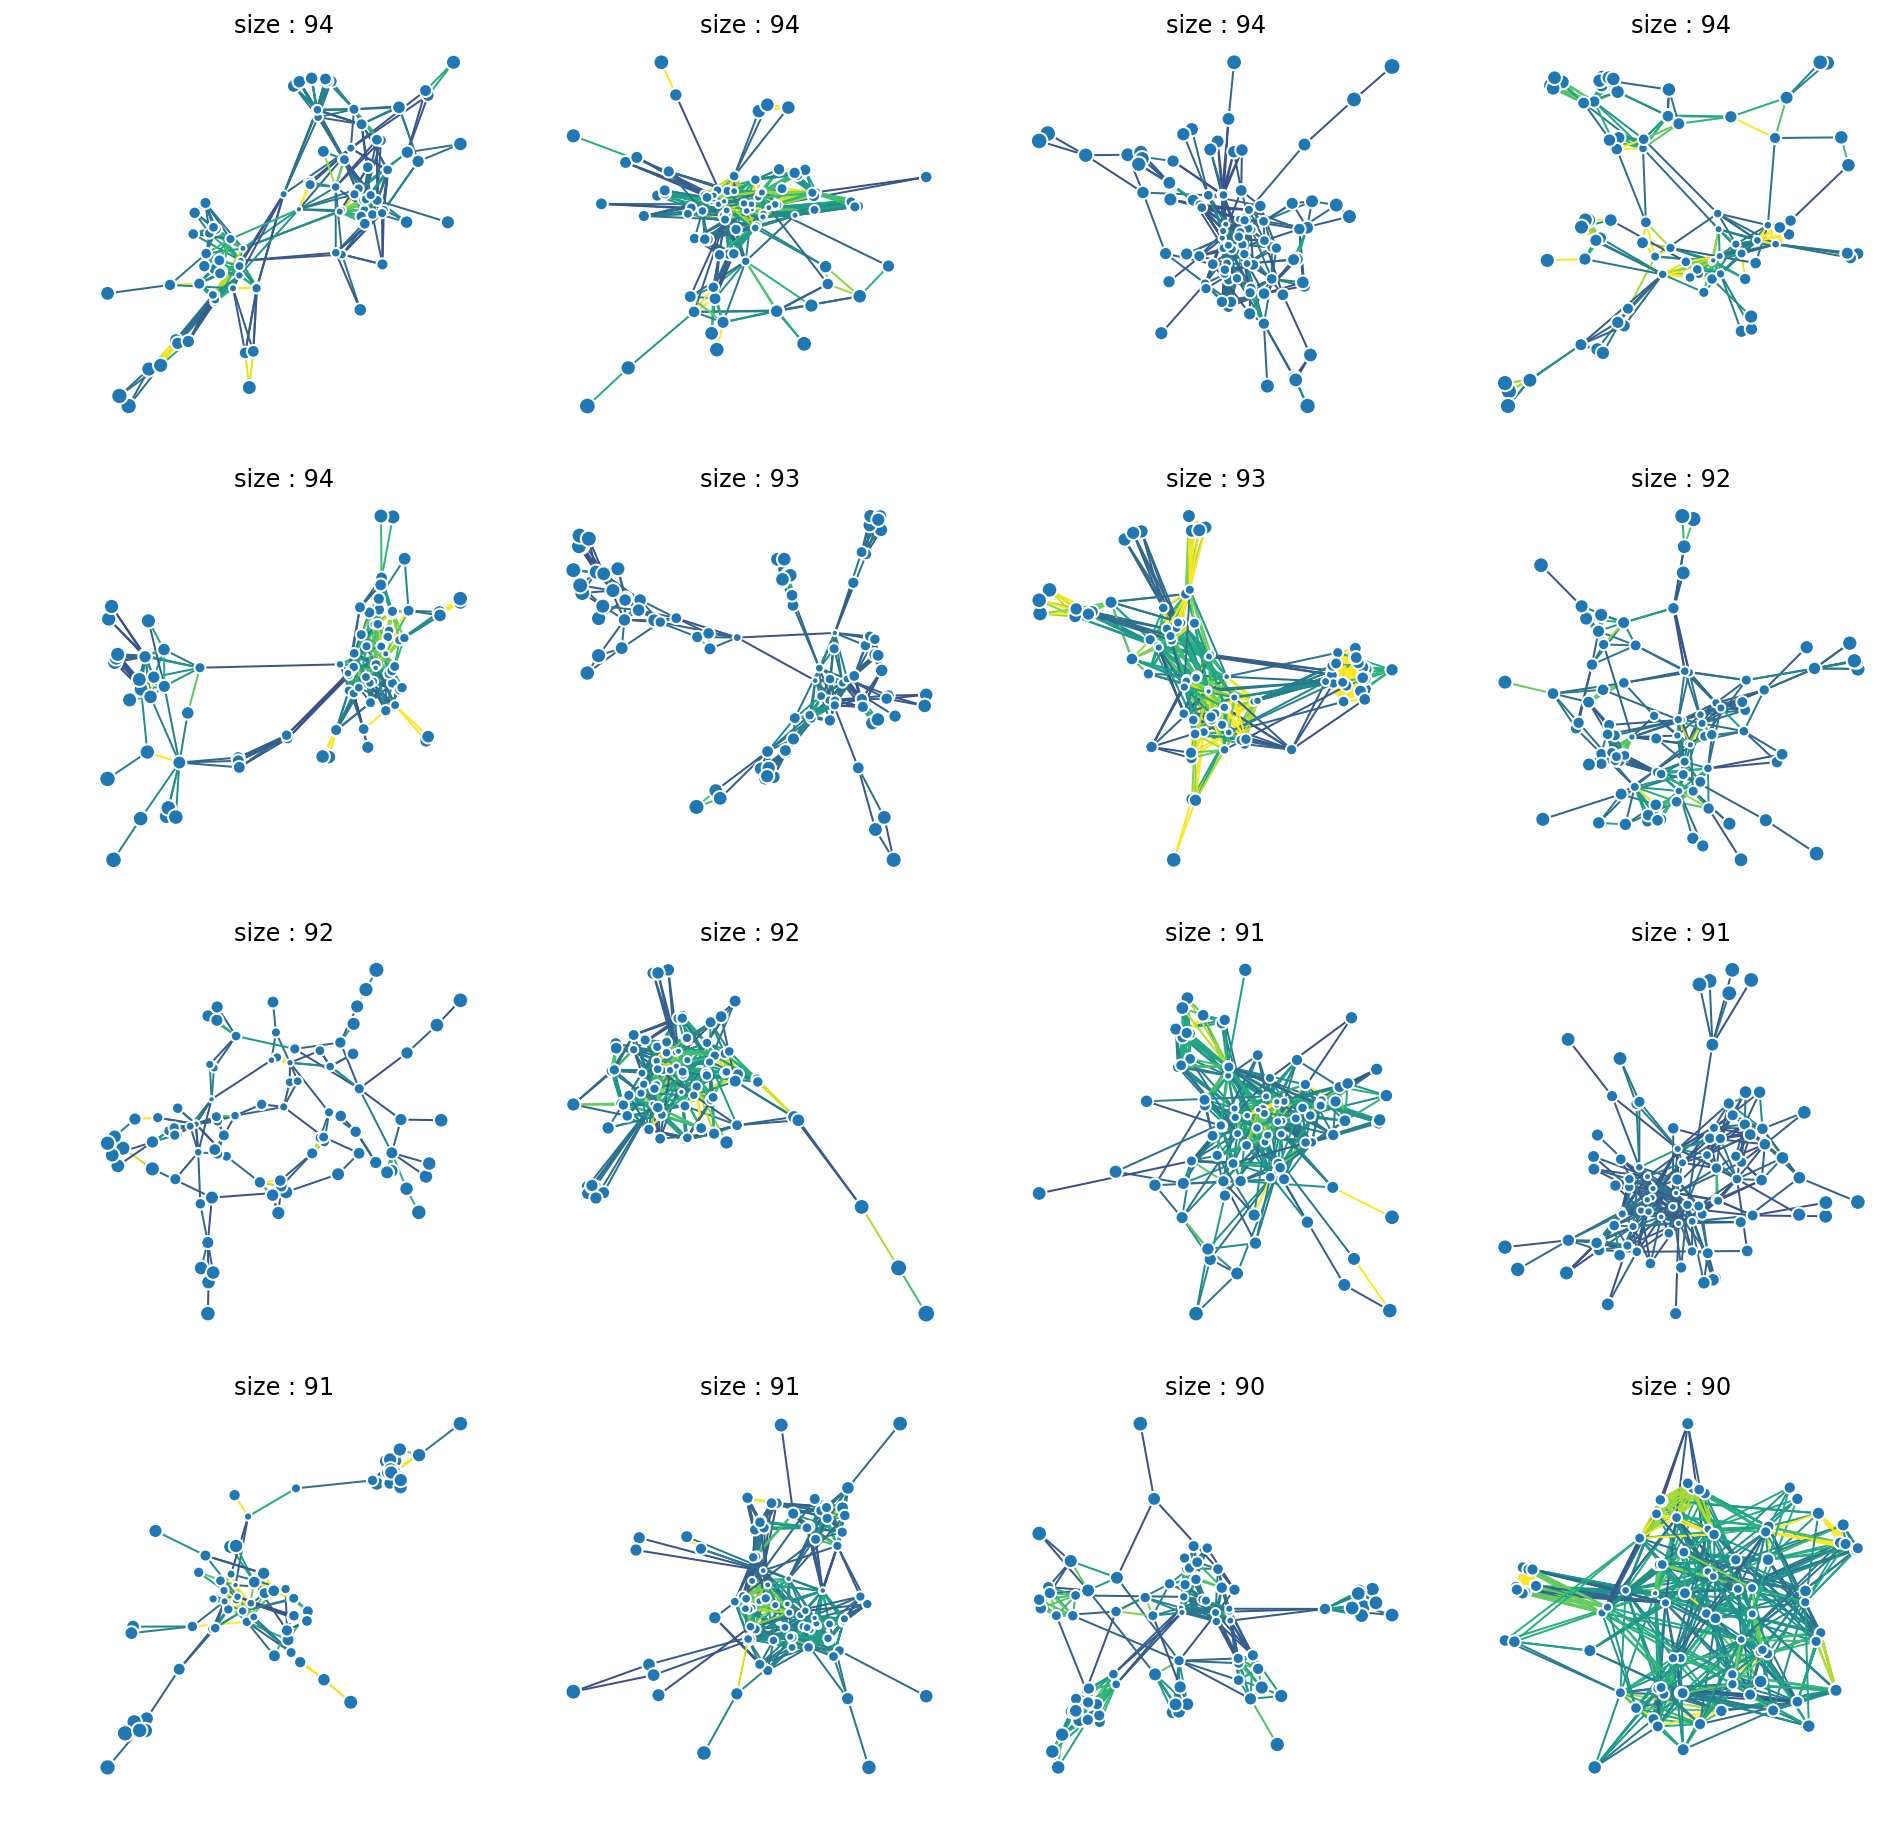

In [8]:
from grave import plot_network, use_attributes

figure( figsize = ( 16, 16 ) )

#def edge_style(edge_attrs):
#
#    alpha = edge_attrs['weight'] / 1000
#    return {'color' : 'black', 'alpha' : alpha }

def edge_style( edge_attributes ):
    return { 'linewidth' : edge_attributes.get( 'weight', 1 ) }

for n,g in enumerate(components[ 200:216 ]) :
    subplot( 4, 4, n+1 )
    title( ' : '.join( map( str, ('size', len(g) ) ) ) )
    
    centrality = networkx.closeness_centrality( g )
    max_centrality = max( centrality.values() )
    
    for node, node_attributes in g.nodes.data():
        node_attributes['size'] = ( 1 - ( centrality[node] /
                                    max_centrality) + .1 ) * 100
    
    
    for u, v, edge_attributes in g.edges.data():
        #c = (centrality[u] +
        #     centrality[v]) / 2
        #color_idx = (c / max_centrality)
        color_idx = ( edge_attributes['weight'] / bit_med )
        cmap = get_cmap()
        edge_attributes['color'] = cmap(color_idx)
        edge_attributes['width'] = 2
    
    #grave.plot_network( g, layout='spring', edge_style=edge_style )
    plot_network( g, layout='spring',
                  node_style=use_attributes(),
                  edge_style=use_attributes('color') )

## Phylogeography

#### Build phylogenetic trees from full-length alignments of protein families

We already have pairwise-alignments of our protein sequences from LAST, but now we want
multiple sequence alignments for each of the protein families using
[Clustal Omega](http://www.clustal.org/omega/). We'll use the MSAs to build approximate 
maximum likelihood trees using [`fasttree`](http://www.microbesonline.org/fasttree/).

In [33]:
import subprocess
from os.path import splitext
from os import environ

def clustalo( fasta_file, threads=1 ) :
    
    base = splitext(fasta_file)[0]
    alignment_file = base + '_clustalo.fasta'
    log_file = base + '_clustalo.log'

    args = ['clustalo', '-v', '--force',
            '-i', fasta_file,
            '--outfmt=fasta',
            '--threads=' + str(threads),
            '-o', alignment_file,
            '-l', log_file ]

    subprocess.call( args )
    return alignment_file


def fasttree( alignment_file, threads=1 ) :
    
    base = splitext(alignment_file)[0]
    tree_file = base + '_fasttree.tree'
    log_file = base + '_fasttree.log'
    
    e = environ
    e['OMP_NUM_THREADS'] = str(threads)
    
    args = ['FastTreeMP', '-gtr', '-log', log_file ] 

    with open( tree_file, 'w' ) as outfile:
        with open( alignment_file, 'r' ) as infile:
            proc = subprocess.Popen( args, env=e, stdout=outfile, stdin=infile )
            proc.wait()
    
    return tree_file

In [34]:
from tempfile import mkdtemp

N = 10000
progbar = pyprind.ProgBar( N-1, title='building trees for protein families...' )

treefiles = []
scratch = mkdtemp()
    
for n,g in enumerate( components[1:N] ) :

    progbar.update()   
    fasta = scratch + '/' + str(n) + '.fa'
    
    with open( fasta, 'w' ) as f :
        
        # generate FASTA file for protein family
        for node in g.nodes :
            f.write( '> ' + str(node) + '\n' + str(viralgenes[node].sequence) + '\n' )
        
    # build alignment and 
    treefiles.append( fasttree( clustalo( fasta, threads=40 ), threads=40 ) )

building trees for protein families...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 05:59:23


In [36]:
progbar = pyprind.ProgBar( len(treefiles), title='loading trees for protein families...' )
trees = []
for treefile in treefiles :
    progbar.update()
    trees.append( SuchTree( treefile ) )

loading trees for protein families...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:51


#### Load sample and mVC metadata

The metadata table contains some mVC's (metagenomic viral contigs, or putative viral genomes)
that we don't actually want because they come from samples that are not soil. So, we need to
remove them from the table before we continue.

In [37]:
metadata = pandas.read_csv( 'data/metadata.csv', sep=',', index_col=0, low_memory=False )

print( 'total records :', metadata.shape[0] )

filtered_mVCs = []
for line in open( 'data/soil_contigs.txt' ).readlines() :
    filtered_mVCs.append( line.replace( '.a:', '_____' ).strip() )
    
print( 'records to drop :', len( set( metadata.index ) ^ set( filtered_mVCs ) ) )

metadata = metadata.drop( set( metadata.index ) ^ set( filtered_mVCs ), axis=0 )
print( 'records retained :', metadata.shape[0] )

total records : 36384
records to drop : 12050
records retained : 24334


#### Extract sample geolocations

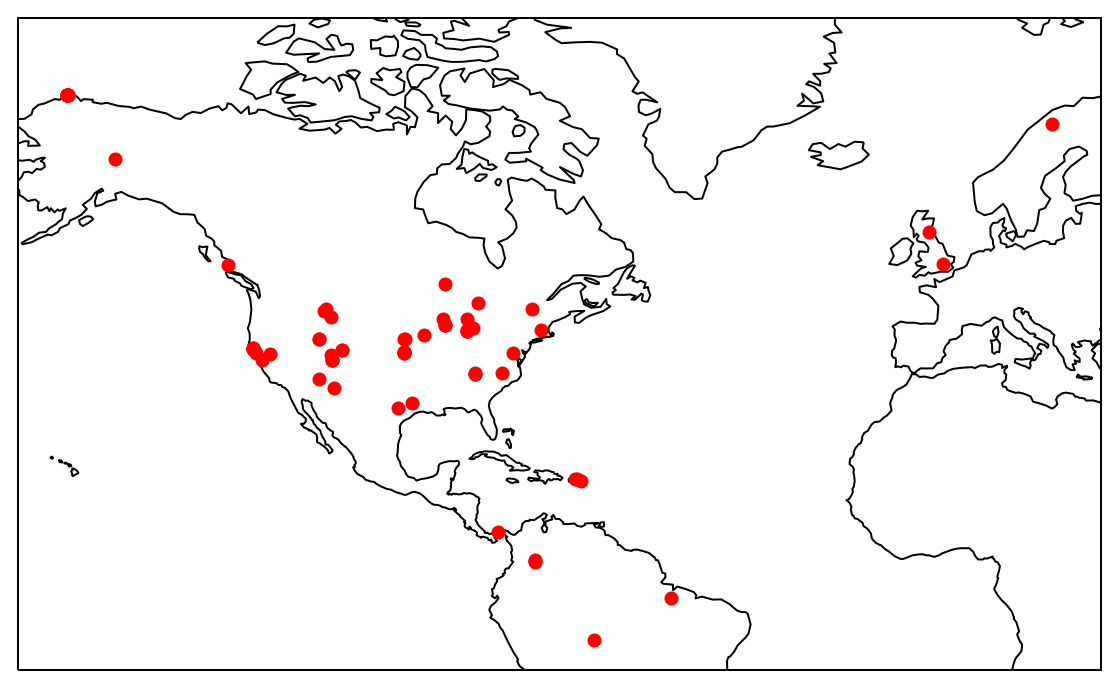

In [38]:
figure( figsize=(12,6) )

# this is kinda horrible, but whatever
locstrings = set( ','.join( (str(a),str(b)) ) for a,b in zip( list( metadata.Latitude ), 
                                                              list( metadata.Longitude ) ) ) 

locations = []
for locstring in locstrings :
    lat, lon = locstring.split(',')
    if lat == 'nan' : continue
    locations.append( ( float(lat), float(lon) ) )

ax = plt.axes( projection=cartopy.crs.Miller() )
#ax.add_image( GoogleTiles( style='satellite' ), 3 )
ax.coastlines()

y, x = zip(*locations)
plot( x, y, 'ro', transform=cartopy.crs.Geodetic() )

#### Haversine (great circle) distances

In [60]:
from math import radians, cos, sin, asin, sqrt
from itertools import combinations

def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    
    https://stackoverflow.com/questions/4913349/#4913653    
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

def geo_distance_pairs( tree ) :
    node_locations = {}
    for node in tree.leafs.keys() :
        mVC = '_____'.join( node.split('_____')[:2] )
        #if mVC in metadata.index : continue
        lat = metadata.loc[ mVC ].Latitude
        lon = metadata.loc[ mVC ].Longitude
        #if isnan(lat) or isnan(lon) : continue
        node_locations[node] = ( lat, lon )

    for node1, node2 in combinations( tree.leafs.keys(), 2 ) :
        lat1, lon1 = node_locations[ node1 ]
        lat2, lon2 = node_locations[ node2 ]
        yield haversine(lon1, lat1, lon2, lat2)

#### Calculate haversine and phylogenetic distances

Text(27.125,0.5,'Phylogenetic distance')

<Figure size 864x432 with 0 Axes>

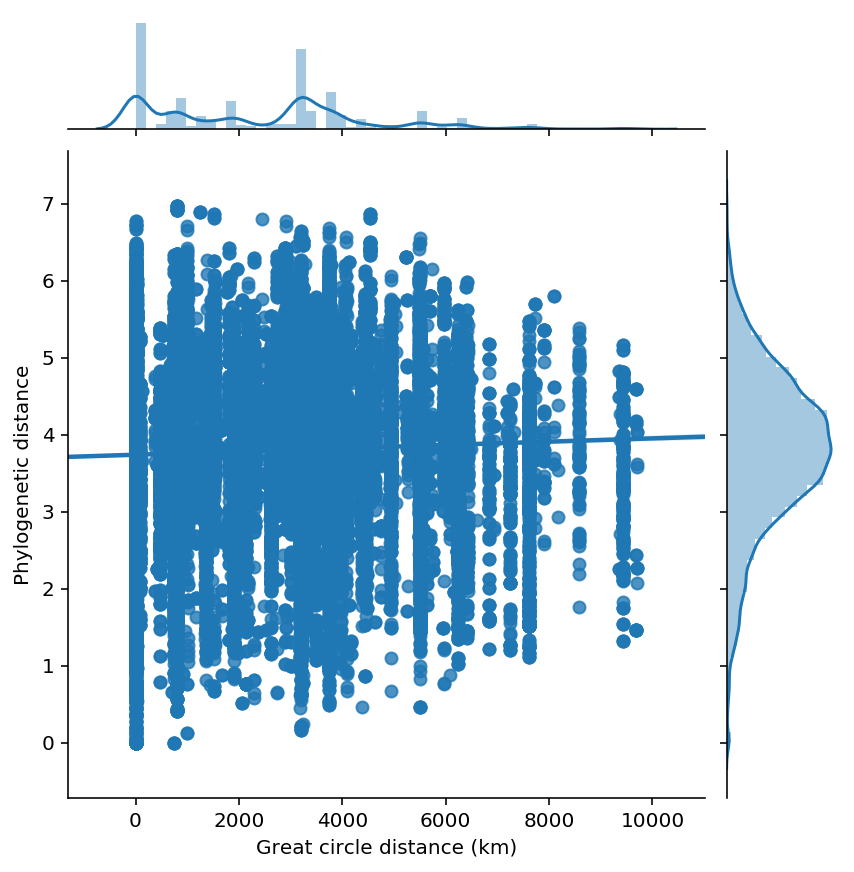

In [114]:
figure( figsize=(12,6) )

tree = trees[25]

geodist = list( geo_distance_pairs( tree ) )
phylodist = tree.distances_by_name( list( combinations( tree.leafs.keys(), 2 ) ) )

seaborn.jointplot( geodist, phylodist, kind='reg' )
xlabel( 'Great circle distance (km)' )
ylabel( 'Phylogenetic distance' )

In [91]:
progbar = pyprind.ProgBar( len(trees), title='calculating geographic and phylogenetic distances for protein families...' )

distances = []
for tree in trees :
    progbar.update()
    
    geodist = list( geo_distance_pairs( tree ) )
    phylodist = tree.distances_by_name( list( combinations( tree.leafs.keys(), 2 ) ) )
    
    # drop cases where the geographic distance is undefined
    gd = delete( geodist,   argwhere( isnan(geodist) ) )
    pd = delete( phylodist, argwhere( isnan(geodist) ) )
    
    distances.append( ( gd, pd ) )

calculating geographic and phylogenetic distances for protein families...
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:10


#### Calculate correlations between haversine and phylogenetic distances, correct p-values for multiple tests 

We use Kendall's $\tau$ rank-order correlation because we cannot assume that the distributions
of either distance measure will be normal. Then, we apply the 
[Simes-Hochberg](https://en.wikipedia.org/wiki/Family-wise_error_rate) step-up procedure to correct
the p-values for multiple  tests.


In [175]:
from scipy.stats import pearsonr, kendalltau
from statsmodels.stats.multitest import multipletests

correlations = pandas.DataFrame( kendalltau(a,b) for a,b in distances )

correlations['size'] = [ tree.n_leafs for tree in trees ]
correlations['total_pd'] = [ sum( tree.adjacency()['adjacency_matrix'] ) / 2.0 for tree in trees ]
correlations['aspect'] = [ sum( tree.adjacency()['adjacency_matrix'] ) / ( 2.0 * tree.n_leafs ) for tree in trees ]

reject, corrected_p, alphacSidak, alphacBonf = multipletests( correlations.dropna().pvalue, 
                                                              alpha=0.05,
                                                              method='simes-hochberg' )

correlations['reject'] = pandas.DataFrame( reject, index=correlations.dropna().index )
correlations['corrected_p'] = pandas.DataFrame( corrected_p, index=correlations.dropna().index )

print( 'protein families with statisticailly significant phylogeography :', 
       correlations[ correlations.reject == True ].shape[0] )

correlations.head()

protein families with statisticailly significant phylogeography : 1242


,correlation,pvalue,size,total_pd,aspect,reject,corrected_p
0,0.051172,0.000000e+00,2155,1038.831618,0.482056,True,0.000000e+00
1,0.005041,4.074258e-10,1235,278.769138,0.225724,True,2.644601e-06
2,-0.008637,3.839681e-12,799,416.604089,0.521407,True,2.542253e-08
3,-0.000881,5.297023e-01,699,311.852587,0.446141,False,1.000000e+00
4,0.028334,4.647132e-77,644,275.972912,0.428529,True,3.245092e-73


Let's look at the distribution of correlations for the protein families where we can
reject the null hypothesis.

([<matplotlib.axis.XTick at 0x2aeb6f6da320>,
 <a list of 5 Text xticklabel objects>)

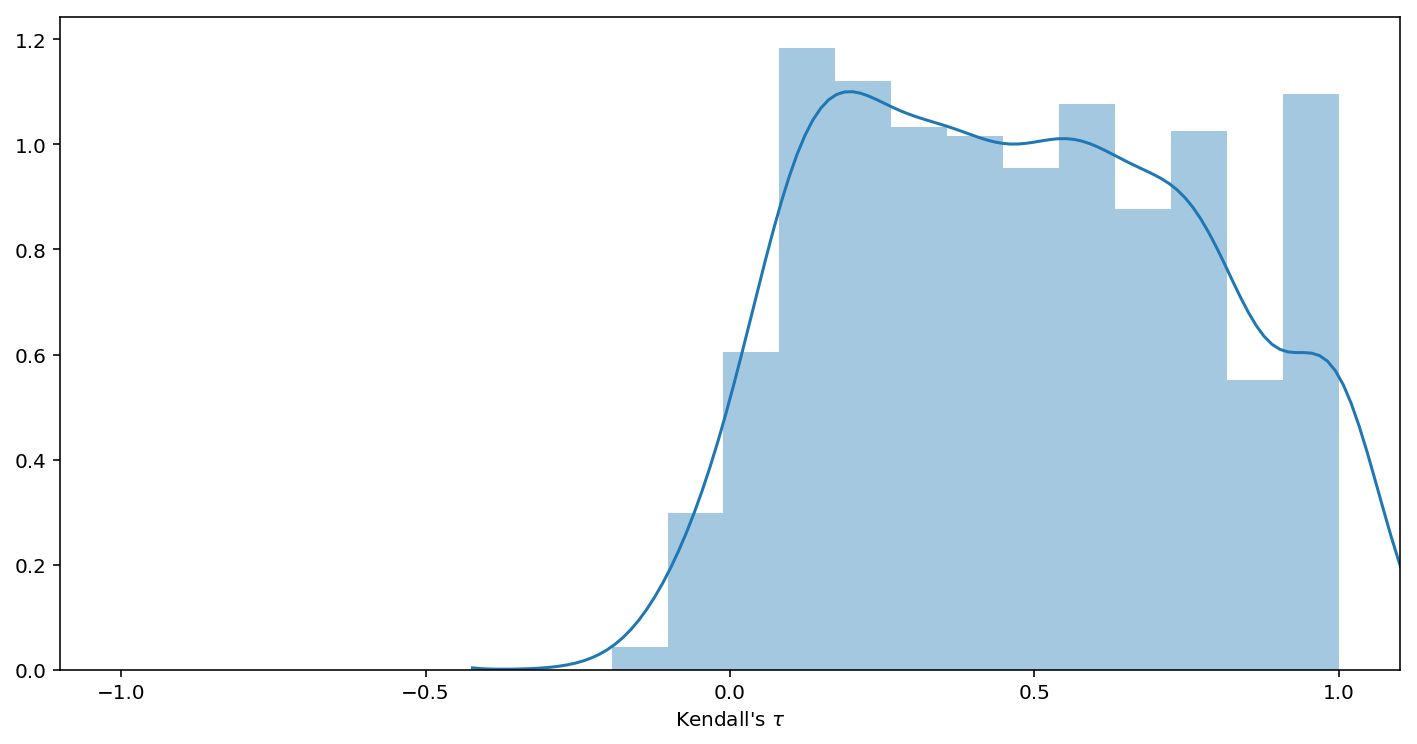

In [165]:
figure( figsize=(12,6) )

seaborn.distplot( correlations[ correlations.reject == True ].correlation )
xlabel( r"Kendall's $\tau$" )
xlim( -1.1, 1.1 )
xticks( [-1, -0.5, 0.0, 0.5, 1 ])

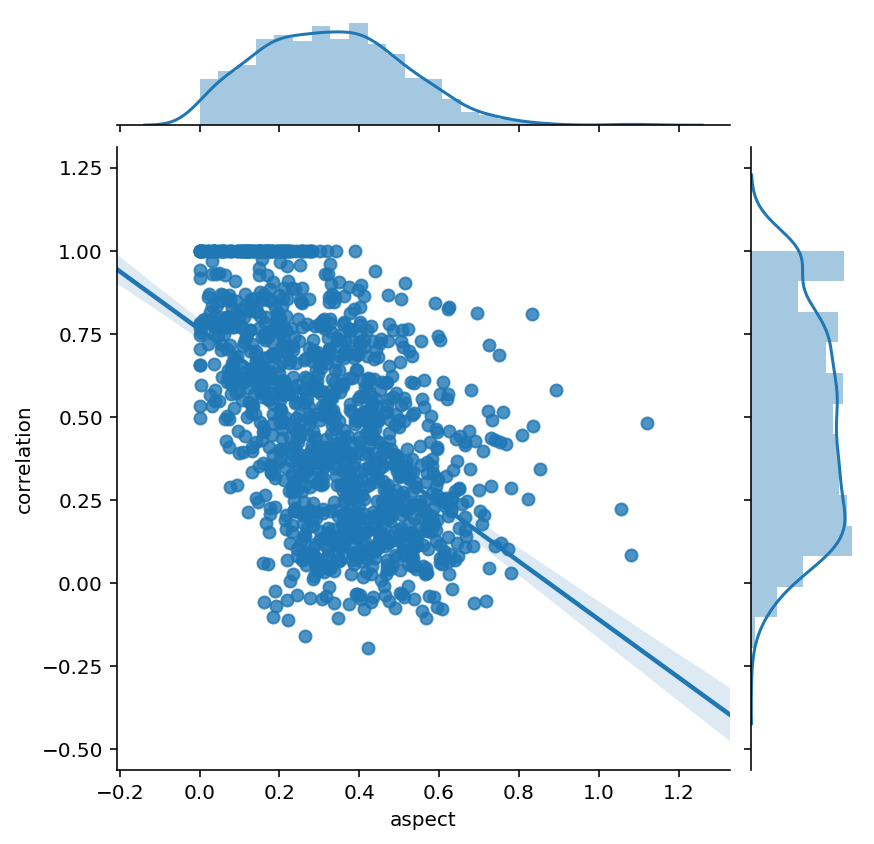

In [170]:

seaborn.jointplot( x='aspect', y='correlation', data=correlations[ correlations.reject == True ], kind='reg' )

Protein families with a higher aspect ratio (total phylogenetic distance per member) tend to have lower
correlations between their geographic distance and phylogenetic distances. This suggests that the biogeography
of viral protein families is driven by founder effects, not allopatric speciation.

## References

<div class="cite2c-biblio"></div>